### 반려동물 건강검진 데이터 추출 파이프라인 테스트

본 문서는 다양한 포맷의 검사결과지 이미지에서 원하는 표준 JSON 형태로 데이터를 추출하기 위한 전체 절차와 세부 규칙(규칙 기반 + LLM 보조)을 정리합니다. OCR은 `PaddleOCRService`로 수행하고, 라인 그룹핑/값·단위 분리는 4.x 단계의 `LinePreprocessor`에서 처리합니다. 상위 추출 로직은 별도 모듈로 확장합니다.

### 현재 검사결과지 테이블 헤더 현황

실제 현업에서 수집되는 검사결과지는 병원/장비/출력 양식에 따라 포맷 편차가 큽니다. 특히 테이블 헤더의 구성과 순서가 일정하지 않으며, 동일 문서 내에서도 페이지 또는 섹션에 따라 달라질 수 있습니다. 대표적인 변형 예시는 다음과 같습니다.

- {`Name`, `Reference`, `Result`, `Unit`}
- {`검사항목`, `참조치`, `결과`, `단위`}
- {`Name`, `Unit`, `Reference`, `YY-MM-DD`}
- {`Name`, `Unit`, `Min`, `Max`, `Result`}

관찰된 특징:
- 동일 의미 컬럼의 명칭이 한글/영문/약어로 혼재(예: 검사항목/Name, 참조치/Reference)
- 컬럼 순서가 바뀌거나, 날짜 같은 비정형 컬럼이 헤더에 포함되는 경우 존재
- 참조범위가 한 칸(`Reference`에 "a–b")에 합쳐지기도 하고, `Min`/`Max`로 분리되기도 함
- `Unit`이 `Result`의 좌/우 어디에 위치할지 일정하지 않음

본 파이프라인은 위 변동성을 고려하여:
- 5단계에서 “바디 시작 라인”을 검사코드 사전 적중으로 고정하고,
- 6단계에서 표준 키워드 3개 이상 매칭 시 헤더 유효로 간주하며,
- 7단계에서 헤더가 없거나 불충분할 때 “열 경계대 + 규칙 기반 추론(LLM 백업)”으로 열 라벨을 안정적으로 복원합니다.

### 목표 데이터 포맷과 유효성

출력 JSON 스키마(필수/선택):

```jsonc
{
  "hospital_name": "OOOOOOO",        // optional
  "client_name": "OOOOOOO",          // optional
  "patient_name": "OOOOOOO",         // optional 
  "inspection_date": "YYYY-MM-DD",   // optional (탐지 실패 시 None 가능)
  "tests": [                         // required 
    { "code": "RBC", "unit": "K/µL", "reference_min": 6.54, "reference_max": 12.2, "value": 6.79 },
    { "code": "ALT", "unit": "%", "reference_min": null, "reference_max": null, "value": 23 },
    ...
  ]
}
```

유효성 기준:
- `tests` 배열이 비어있지 않으면 유효로 간주합니다.

### Step 1. 빈 결과 초기화

- 최종 결과 컨테이너 `doc_result`를 아래 키로 초기화
  - hospital_name, client_name, patient_name, inspection_date, tests([])

In [1]:
from typing import Any, Dict, List
import json
import time

# Pipeline 시작 시간 기록
pipeline_start_time = time.time()
print(f"⏱️ Pipeline 시작 시간: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(pipeline_start_time))}")

DocumentResult = Dict[str, Any]


def init_doc_result() -> DocumentResult:
    """표준 결과 컨테이너 초기화.
    Keys:
      - hospital_name: str | None
      - client_name: str | None
      - patient_name: str | None
      - inspection_date: str | None (YYYY-MM-DD)
      - tests: list[dict]
    """
    return {
        "hospital_name": None,
        "client_name": None,
        "patient_name": None,
        "inspection_date": None,
        "tests": [],
    }


def validate_doc_result(doc: DocumentResult) -> tuple[bool, str]:
    """최소 유효성 검증: tests 존재 여부.
    returns: (is_valid, message)
    """
    if not doc.get("tests"):
        return False, "tests 비어있음"
    return True, "ok"


# 실행 예시
_doc = init_doc_result()
print("✅ 초기화된 결과 컨테이너:")
print(json.dumps(_doc, ensure_ascii=False, indent=2))
print("유효성:", validate_doc_result(_doc))

⏱️ Pipeline 시작 시간: 2025-10-23 02:44:19
✅ 초기화된 결과 컨테이너:
{
  "hospital_name": null,
  "client_name": null,
  "patient_name": null,
  "inspection_date": null,
  "tests": []
}
유효성: (False, 'tests 비어있음')


### Step 2. 이미지 전처리 (PaddleOCR 친화)

순서 및 목적:
1. flatten_transparency – 투명 픽셀을 흰 배경으로 플래튼
2. normalize_mode – 이미지 모드 정규화(L/RGB)
3. upscale_min_resolution – 최소 해상도 확보(롱엣지 ≥ 1920 권장)
4. suppress_glare – 반사/하이라이트 감쇠
5. weak_autocontrast – 약한 대비 개선(과도 금지)
6. blacken_reddish_text, blacken_bluish_text – 색 텍스트 흑화(있을 때만)
7. to_grayscale – 회색화
8. conditional_dewarp – 곡면/말림 보정(필요 시만)
9. deskew_textlines – 미세 기울기 보정(OSD + 라인 스코어)
10. enhance_table_lines – 표 라인 약 강화(보수적 파라미터)
11. downscale_target_long_edge – 추론 적정 크기로 다운스케일(예: 1920)
12. conservative_sharpen – 보수적 샤프닝

품질 게이트(권장): 전처리 전후 Tesseract 기반 빠른 메트릭으로 토큰 수/평균 신뢰도 개선이 없으면 원본 사용을 유지(롤백).


In [2]:
import os

# img_path = os.path.abspath('notebooks/ocr/assets/images/test_image_1.jpg')

# img_path = os.path.abspath('notebooks/ocr/assets/images/20241106.jpg')   # ---------- 날짜가 여러개
img_path = os.path.abspath('notebooks/ocr/assets/images/20241107_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241107.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241121_2.png')  # ---------- 날짜 없는것
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241121.png')    # ---------- 사진으로 짝어서 삐뚤어진것
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241123_2.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241123.png')    # ---------- 인쇄일자만 있음
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241205_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241205.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241219.png')    # ---------- 사진으로 짝어서 삐뚤어진것
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241221_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241221.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241224_2.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241224.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241231.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250107.png')    # ----------
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250110.png')    # ---------- 데이블 구조 특이한것. value 열 레이블이 날짜임
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_2.png')  
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_3.png')  # ---------- blue 글자 인식이 잘 안됨
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_4.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119_2.png')  # ---------- 흐릿한 이미지 폰트색상 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119_3.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119.png')    # ---------- 흐릿한 이미지
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250125.jpeg') # ----------   
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250203.jpeg') # ----------  
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250207.jpeg') # ----------   
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250209.jpeg') # ----------  
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250216.jpeg') # ----------  
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250222.png') # ----------  
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250228.png') # ----------   
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250301.png')



# img_path = os.path.abspath('notebooks/ocr/assets/images/20250125.jpeg')



print(f"분석할 이미지: {img_path}")  

분석할 이미지: /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20241107_2.jpg


In [3]:
# ImagePreprocessor 초기화
from app.services.analysis.image_preprocessor import ImagePreprocessor, Settings as IPS

ip = ImagePreprocessor(IPS(
    long_edge_min=1920,
    # enable_to_grayscale=True,
    debug=True,
))

In [4]:
# 이미지 파일을 읽고 전처리하여 바이트로 변환
with open(img_path, 'rb') as f:
    _raw_bytes = f.read()

# 클래스 기반 전처리 실행 (디버그 로그 포함: 데스큐 각도, 용량 변화 등)
_pre_bytes = ip.process_bytes(_raw_bytes, debug=True)
# _pre_bytes = _raw_bytes # PaddleOCR 은 전처리 안하는게 더 나은것 같음
print("✅ ImagePreprocessor 로 전처리 완료")

🏥 이미지 전처리 시작 (ImagePreprocessor)
📏 원본 이미지 크기: (794, 1123)
📐 최종 이미지 크기: (1358, 1920)
🔄 크기 변화: (794, 1123) → (1358, 1920)
💾 용량 변화: 159,272 bytes → 845,718 bytes (531.0%)
✅ 전처리 완료
✅ ImagePreprocessor 로 전처리 완료
📐 최종 이미지 크기: (1358, 1920)
🔄 크기 변화: (794, 1123) → (1358, 1920)
💾 용량 변화: 159,272 bytes → 845,718 bytes (531.0%)
✅ 전처리 완료
✅ ImagePreprocessor 로 전처리 완료


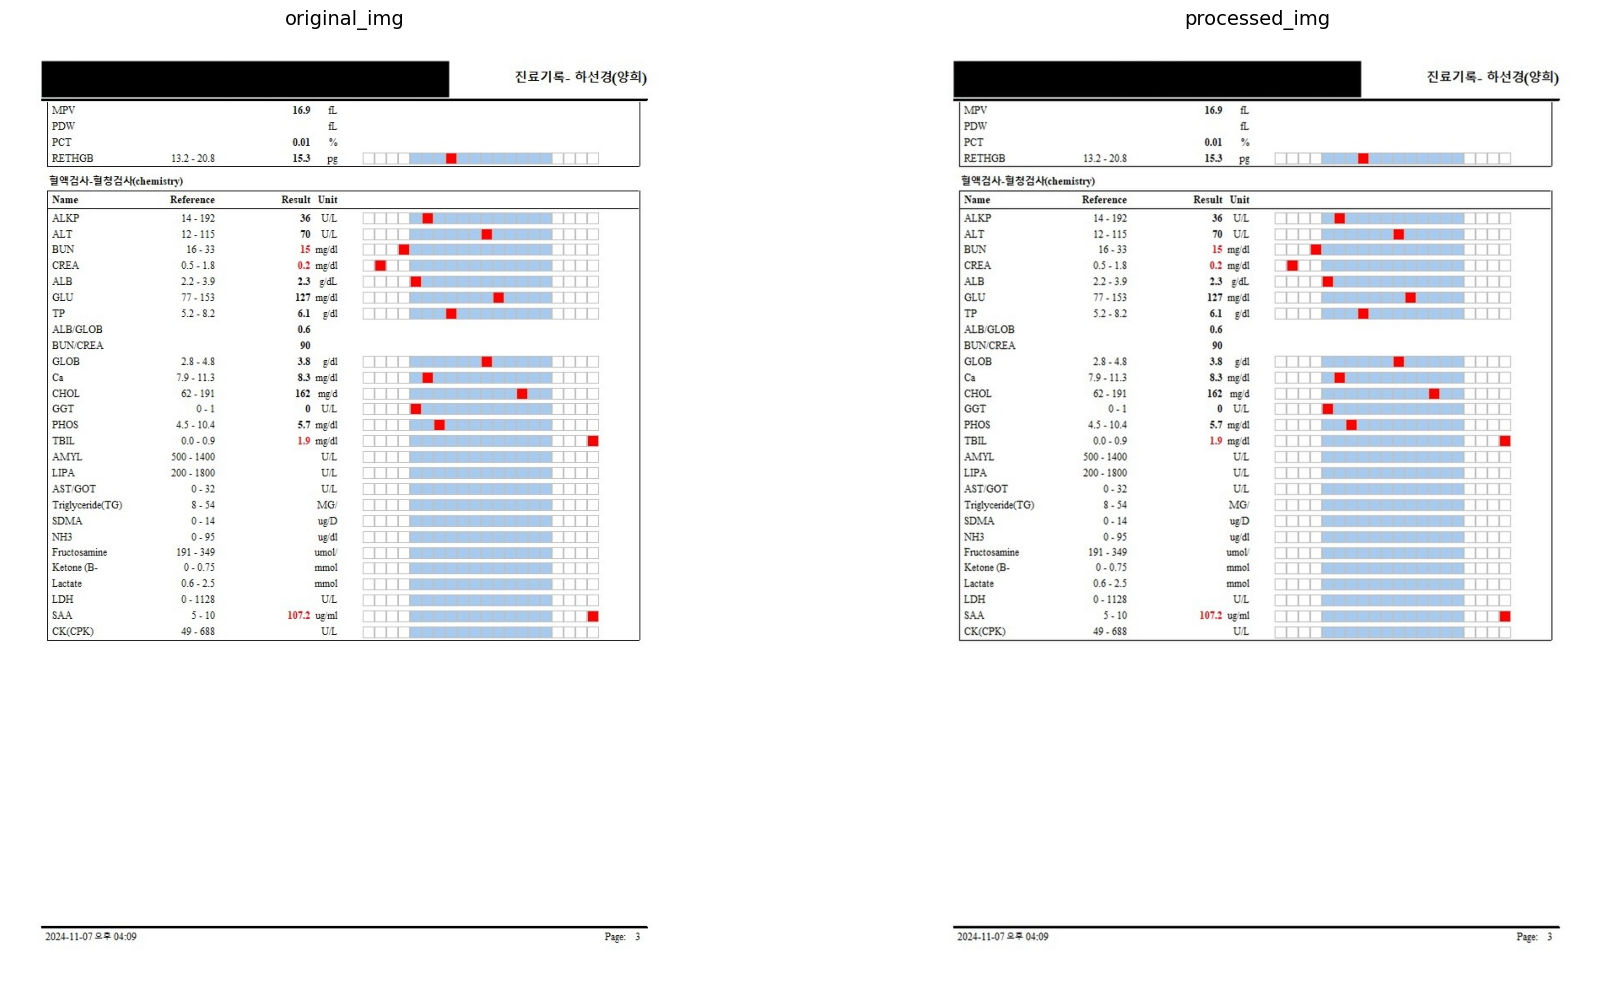

In [5]:
import io
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# bytes를 PIL Image로 변환
processed_img = PILImage.open(io.BytesIO(_pre_bytes))

# 원본과 전처리된 이미지를 함께 표시
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 원본 이미지
original_img = PILImage.open(img_path)
axes[0].imshow(original_img)
axes[0].set_title('original_img', fontsize=14)
axes[0].axis('off')

# 전처리된 이미지
if processed_img.mode == 'L':  # 그레이스케일
    axes[1].imshow(processed_img, cmap='gray', vmin=0, vmax=255)
else:  # 컬러
    axes[1].imshow(processed_img)
axes[1].set_title('processed_img', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Step 3. PaddleOCR 수행

초기화(예):
- `PaddleOCR(lang="korean", use_doc_orientation_classify=True, use_textline_orientation=True)`

출력: 원본 결과를 `PaddleOCRService.extract_and_group_lines()`로 전달할 준비.

In [6]:
# PaddleOCRService 초기화
import paddleocr
from paddleocr import PaddleOCR
import inspect
from app.services.ocr.paddle_ocr import PaddleOCRService

# 서버급 조합(정확도 지향): PP-OCRv5_server_det + korean_PP-OCRv5_server_rec
# 필요 시 파라미터는 추가로 조정 가능: text_det_limit_side_len, text_det_thresh, text_rec_score_thresh 등
ocr = PaddleOCRService(lang="korean")

print(f"\n🔍 현재 PaddleOCR 버전: {paddleocr.__version__}")

# PaddleOCR 생성자의 파라미터 확인
# signature = inspect.signature(PaddleOCR.__init__)
# print(f"\n📋 지원하는 파라미터:")
# for param_name, param in signature.parameters.items():
#     if param_name != 'self':
#         default = param.default if param.default != inspect.Parameter.empty else "필수"
#         print(f"   {param_name}: {default}")  

# ocr.get_available_langs()
# ocr.get_available_models()
# info = ocr.get_current_model_info()
# print(info) 
# ocr.get_current_preprocessing_settings()          

/home/aidan/.local/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/UVDoc`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached


🔍 현재 PaddleOCR 버전: 3.2.0


In [7]:
# OCR 실행
print(f"🔍 OCR 분석 시작: {img_path}")
try:
    ocr_result = ocr.run_ocr_from_bytes(_pre_bytes)
    print("✅ OCR 처리 완료!")
    print(ocr_result)
except Exception as e:
    print(f"❌ OCR 처리 중 오류 발생: {e}")
    print(f"오류 타입: {type(e).__name__}")

🔍 OCR 분석 시작: /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20241107_2.jpg
✅ OCR 처리 완료!
[{'input_path': None, 'page_index': None, 'doc_preprocessor_res': {'input_path': None, 'page_index': None, 'input_img': array([[[255, ..., 255],
        ...,
        [255, ..., 255]],

       ...,

       [[255, ..., 255],
        ...,
        [255, ..., 255]]], shape=(1920, 1358, 3), dtype=uint8), 'model_settings': {'use_doc_orientation_classify': True, 'use_doc_unwarping': True}, 'angle': 0, 'rot_img': array([[[255, ..., 255],
        ...,
        [255, ..., 255]],

       ...,

       [[255, ..., 255],
        ...,
        [255, ..., 255]]], shape=(1920, 1358, 3), dtype=uint8), 'output_img': array([[[251, ..., 251],
        ...,
        [255, ..., 255]],

       ...,

       [[254, ..., 253],
        ...,
        [251, ..., 251]]], shape=(1920, 1358, 3), dtype=uint8)}, 'dt_polys': [array([[1042,   16],
       ...,
       [1044,   57]], shape=(4, 2), dtype=int16), array([[ 11,  99],
      

### Step 4. 라인 정렬 및 값/단위 분리

#### 4.1 `_extract_tokens_with_geometry` 

- 설명: OCR 결과를 텍스트 기준으로 관련 정보를 묶어 리스트로 반환.
- Returns:

```
list[dict[str, str | float | int | None]]: [
  {
    "text": str,
    "confidence": float | None,
    "y_top": int | None,
    "y_bottom": int | None,
    "y_center": int | None,
    "raw_h": int | None,
    "x_left": int | None,
    "x_right": int | None
  },
  ...
]
```

#### 4.2 `_assign_line_indices_by_y` (반환 형식)

- 설명: 4.1 결과를 순회하며 y_top/y_bottom/y_center/raw_h 정보를 이용해 동일한 텍스트 라인끼리 묶고 `line_index`를 부여합니다.
- Returns:

```
list[dict[str, str | float | int | None]]: [
  {
    "text": str,
    "confidence": float | None,
    "y_top": int | None,
    "y_bottom": int | None,
    "y_center": int | None,
    "raw_h": int | None,
    "x_left": int | None,
    "x_right": int | None,
    "line_index": int | None
  },
  ...
]
```

### 4.3 `_group_tokens_by_line` (반환 형식)

- 설명: 4.2 결과에서 `line_index`가 부여된 토큰들을 라인 단위로 2차원 배열로 묶어 반환합니다.
- Returns:

```
[
  [ {토큰}, {토큰}, {토큰}, {토큰}, {토큰}, ... ],
  [ {토큰}, {토큰}, {토큰}, {토큰}, {토큰}, ... ],
  [ {토큰}, {토큰}, {토큰}, {토큰}, {토큰}, ... ],
  ...
]
```

### 4.4 `_split_line_tokens_preserve_fields` (분리 규칙/입출력)

- 설명: 4.3 결과에서 각 라인·각 토큰을 순회하며, “검사결과값과 단위”가 하나의 텍스트로 묶여 있는 경우를 ‘검사결과 토큰’ + ‘단위 토큰’으로 분리합니다. 원본 필드(x_left/x_right 등)는 보존하되 텍스트만 좌우로 나눕니다.
- 분리 규칙(매칭될 때만 분리):

```
^\s*([-+]?\d+(?:[.,]\d+)?)\s+(.+?)\s*$   # 공백이 있는 경우 (기존)
^\s*([-+]?\d+(?:[.,]\d+)?)([A-Za-zµμ%‰/][\w%‰/µμ]*)\s*$   # 공백 없이 붙은 경우 (신규)
```

즉,
- “값 + 공백 + 단위” 뿐 아니라,
- “값 + 단위(공백 없음)”도 안전하게 분리합니다. 예: `1.9mg/dL`, `7.34%`

- 제외/보호 규칙:
  - 단위 후보에 범위 구분자 포함 시 분리하지 않음: `-`, `–`, `~`
  - 단위 문자열이 지나치게 긴 경우(> 12자) 분리하지 않음
  - 값 뒤 경고 플래그 1글자(H/L/N)만 붙은 형태는 단위로 보지 않음 → 분리하지 않음
    - 예: `"12.3H"`는 4.5에서 value_flag로 주석하고, 여기서는 분해하지 않음

- 1차 단위 처리(분리 직후, 선택적):
  - LinePreprocessor 설정에서 `normalize_units_first_pass=True`인 경우, 분리된 단위 토큰에 대해 “텍스트 변경 없이” 원문을 `raw_unit`으로만 표기합니다.
  - canonical 확정/치환은 수행하지 않습니다. (중복 정규화 방지)
  - 최종 canonical 확정(예: `ugD`→`µg/dL`, `10^3/µL`→`K/µL` 등)은 Step 11에서 한 번만 수행합니다.
  - 애매하거나 불확실한 경우에도 원문을 유지합니다.
  - 참고: OCR 오인식(예: `mg/d1`의 `1`→`L`) 교정 역시 Step 11에서 처리합니다.

- Input 예시:

```
[
  [ {토큰}, {토큰}, {토큰}, {토큰}, {검사결과값 + 단위}, ... ],
  [ {토큰}, {토큰}, {토큰}, {토큰}, {검사결과값+단위(공백없음)}, ... ],
  ...
]
```

- Returns 예시:

```
[
  [ {토큰}, {토큰}, {토큰}, {토큰}, {검사결과토큰}, {단위토큰}, ... ],
  [ {토큰}, {토큰}, {토큰}, {토큰}, {검사결과토큰}, {단위토큰}, ... ],
  ...
]
```

주의/보완:
- 소수점 OCR 대체(·→.), 유니코드 대시/마이너스 통일
- 결과 플래그 H/L/N 분리 가능: `^([-+]?\d+(?:[.,]\d+)?)([HhLlNn])?$` (4.5에서 주석)
- 정성값 pos/neg/양성/음성은 숫자 분리 규칙에서 제외

### 4.5 값 경량 정규화 주석 (H/L/N 접미)

- 목적: 4.4 분리 직후, 공백 없이 수치 뒤에 붙은 H/L/N 접미만 경량 주석한다. 원문 텍스트는 절대 변경하지 않는다.
- 규칙:
  - 정규식: ^([-+]?\d+(?:\.\d+)?)([HLN])$ (공백 불허)
  - 매칭 시 토큰에 아래 필드를 추가한다:
    - raw_value: 원문 문자열
    - value_num: 숫자 부분 문자열
    - value_flag: 'H' | 'L' | 'N'
    - value_norm_stage: 'first_pass'
  - 단위 후보 토큰(_origin == 'split_unit_candidate')는 제외하여 단위와의 충돌을 피한다.
- 비고:
  - 본 단계는 추론 신호 강화가 목적이며, 최종 정규화는 Filling 이후 일괄 수행한다.
  - 공백이 있는 접미("12.3 H")나 서술형 플래그("High")는 여기서 다루지 않는다.

### 4.6 상태 토큰 제거(NORMAL/LOW/HIGH)

- 목적: 표 바디에서 데이터 셀로 쓰이지 않는 상태 라벨(예: NORMAL/LOW/HIGH)을 제거해 라인 구조를 간결하게 만들고, 이후 geometry 기반 Filling의 안정성을 높입니다.
- 적용 시점: 4.4 값·단위 분리와 4.5 값 경량 주석 이후, LinePreprocessor의 `extract_and_group_lines` 내부에서 자동 적용됩니다.
- 구성: 별도의 설정 없이 항상 동작(보수적 규칙만 수행).

동작 규칙
- 제거 대상: 토큰의 텍스트가 다음 중 하나와 “정확히 일치”할 때 제거합니다(대소문자 무시).
  - `NORMAL`, `LOW`, `HIGH`
- 부분 문자열은 제거하지 않습니다.
  - 예: `"HIGHLY"`, `"LOWER"` 등은 보존됩니다.
- 4.5 단계에서 주석되는 “숫자+H/L/N 접미”는 여기서 제거 대상이 아닙니다.
  - 예: `"12.3H"` → 보존(단, value_flag 주석은 유지)

디버그 로그
- 디버그 모드(`debug=True`)에서 제거된 토큰 수를 기록합니다.
  - `[DEBUG] status_tokens_removed_4_6: <count>`
  - 오류 발생 시: `[DEBUG] status_tokens_remove_error_4_6: <message>`

예시
- 입력(라인 토큰): `["HGB", "g/dL", "13.5", "NORMAL"]` → 출력: `["HGB", "g/dL", "13.5"]`
- 입력: `["K", "mmoL/L", "3.2", "LOW"]` → 출력: `["K", "mmoL/L", "3.2"]`
- 입력: `["pH", "7.34", "High"]` → `"High"`는 대소문자 무시 일치이므로 제거됨 → `["pH", "7.34"]`
- 입력: `["note", "HIGHLY"]` → 부분 문자열이므로 보존 → 동일

설계 의도/영향
- 상태 라벨은 결과 값/단위/참조범위를 구성하지 않는 부가 정보로 간주하여 제거합니다.
- 제거로 인해 라인 내 불필요 토큰이 줄어 열 밴드 산정과 1:1 배정(최소비용 매칭)이 단순·견고해집니다.
- LabTableExtractor는 동일 기능을 더 이상 수행하지 않으며(중복 제거), 4.6에서 일원화됩니다.

확장 여지
- 향후 필요 시 `POS/NEG/양성/음성` 등 추가 상태 라벨을 후보로 확장할 수 있습니다(보수적으로 단계적 도입 권장).

In [8]:
# LinePreprocessor 초기화

from app.services.analysis.line_preprocessor import LinePreprocessor, Settings as LPSettings
from app.services.analysis.reference.unit_lexicon import get_unit_lexicon

unit_lex = get_unit_lexicon()  # 전역 유닛 렉시콘(캐시)

lp = LinePreprocessor(LPSettings(
    order="x_left",
    alpha=0.7,
    debug=True,
    normalize_units_first_pass=True,  # 분리 직후 1차 단위 정규화 
), unit_lexicon=unit_lex)


In [9]:
# 4.1 ~ 4.6 통합 실행
ocr_lined_data = lp.extract_and_group_lines(
    ocr_result[0]
)

print("📋 OCR 결과(LinePreprocessor):")
for i, item in enumerate(ocr_lined_data, 1):
    print(f"  {i}. {item}")

[DEBUG] tokens_with_geometry: count=99
[
  {
    "text": "진료기록-하선경(양희)",
    "confidence": 0.9687557220458984,
    "y_top": 0,
    "y_bottom": 57,
    "y_center": 28,
    "raw_h": 57,
    "x_left": 1042,
    "x_right": 1353
  },
  {
    "text": "MPV",
    "confidence": 0.9969701766967773,
    "y_top": 99,
    "y_bottom": 125,
    "y_center": 112,
    "raw_h": 26,
    "x_left": 11,
    "x_right": 72
  },
  {
    "text": "16.9",
    "confidence": 0.9993466734886169,
    "y_top": 101,
    "y_bottom": 131,
    "y_center": 116,
    "raw_h": 30,
    "x_left": 549,
    "x_right": 601
  },
  {
    "text": "fL",
    "confidence": 0.9809324741363525,
    "y_top": 105,
    "y_bottom": 135,
    "y_center": 120,
    "raw_h": 30,
    "x_left": 630,
    "x_right": 659
  },
  {
    "text": "PDW",
    "confidence": 0.8830717206001282,
    "y_top": 133,
    "y_bottom": 159,
    "y_center": 146,
    "raw_h": 26,
    "x_left": 10,
    "x_right": 70
  },
  {
    "text": "fL",
    "confidence": 0.8689980506

### Step 5. 테이블 바디 시작 검출 및 바디 필터링

핵심 아이디어: 라인의 첫 토큰이 “검사항목 코드”로 해석되면 그 라인을 바디 시작으로 간주.

구현 요약:
- 코드 사전 매칭: 전역 코드 렉시콘을 사용하여 첫 토큰을 `resolve_code()`로 해석(정규화)합니다.
- 스캔 방향: 위→아래로 순차 스캔하여 최초 적중 라인의 인덱스를 바디 시작으로 고정합니다.
- 바디 필터링: 바디 시작 이후의 라인 중 첫 토큰이 코드로 해석되지 않는 라인은 바디에서 제거합니다.
- 코드 정규화: 바디로 채택된 라인의 첫 토큰 텍스트는 “정규화된 canonical 코드”로 교체하여 이후 단계(헤더 검증/추론, Filling 등)의 일관성을 확보합니다.
  - 예시: `NEU`/`NEUT`/`GRAN` → `NEUT`, `LYM`/`LYMPH` → `LYM`, `RDWSD` → `RDW-CV`, `BASO (%)` → `BASO(%)`
  - `RETIC#`처럼 `#` 접미는 유지합니다.
  - `-A` 접미는 “기본형 코드가 렉시콘에 존재”하면 제거하여 기본형으로 매핑합니다(예: `RETIC-A` → `RETIC`).
  - OCR 혼동 보정: 숫자 `0`과 알파벳 `O` 혼동(p02 ↔ pO2, C02 ↔ CO2 등)을 완화하기 위해 `resolve_code()`는 마지막 폴백으로 `0→O` 치환 후 재매칭을 시도합니다(과도한 오인식 방지 위해 보수적으로 적용).

실패 처리:
- 시작 라인 미검출 시 테이블 파싱을 중단하고 사유를 디버그 정보에 기록합니다(정상 문서로 간주하지 않음). 상단 메타데이터 추출도 스킵합니다.

디버그:
- `debug_step5(...)`로 바디 시작 인덱스, 바디 프리뷰, 제거된 라인 목록(이유 포함)을 확인할 수 있습니다.

In [10]:
# 검사항목 코드 목록
import importlib
import app.services.analysis.reference.code_lexicon as cl
cl = importlib.reload(cl)  # 모듈 재로딩: 새로운 resolve_code 로직 반영

# 최신 렉시콘 획득 (캐시 재빌드는 참조 데이터가 바뀔 때만 필요)
code_lexicon = cl.get_code_lexicon()
codes = sorted(cl.list_all_codes())
print(f"\n📋 테스트용 코드 렉시콘 (총 {len(codes)}개, 상위 80개 미리보기):")
print(", ".join(codes[:80]))

# 가벼운 리졸버 자체 테스트 (OCR 0↔O 보정 확인)
for s in ["p02", "P02(T)", "p02(A-a)", "s02", "pO2", "sO2", "CO2", "C02"]:
    print(f"  {s!r} -> {cl.resolve_code(s, code_lexicon)}")



📋 테스트용 코드 렉시콘 (총 156개, 상위 80개 미리보기):
AG, ALB, ALB/GLOB, ALKP, ALP, ALT, AMYL, AST, AST/GOT, A_G, Albumin, AnGap, BA, BASO, BB, BE, BE(Art), BE(Ven), BE-Ecf, BIL, BIL-Total, BLO, BP, BUN, BUN/CRE, BUN/CREA, Bacteria, CHOL, CHOL_HDL_RATIO, CHr, CK, COHb, CORT, CPK, CRE, CREA, CRP, Ca, Ca++, Cl-, Crystals, EOS, FHHb, FIB, FIV, FO2Hb, FSAA, FT4, FeLV, Fructosamine, GGT, GLOB, GLOB(calc), GLU, GLU_U, Globulin, HCO3, HCO3(Art), HCO3(Ven), HCO3-Std, HCT, HDL_C, HGB, Heartworm Ag, IP, K+, KET, LAC, LDH, LDL_C, LIPA, LYM, LYMPH, LYMPHO, Lac(Art), Lac(Ven), Lactate, MCH, MCHC, MCV
  'p02' -> pO2
  'P02(T)' -> PO2(T)
  'p02(A-a)' -> pO2(A-a)
  's02' -> sO2
  'pO2' -> pO2
  'sO2' -> sO2
  'CO2' -> None
  'C02' -> None


In [11]:
# LabTableExtractor 초기화, 실행
import importlib
import app.services.analysis.lab_table_extractor as lte
lte = importlib.reload(lte)
LabTableExtractor = lte.LabTableExtractor
Settings = lte.Settings

# 최신 code_lexicon 모듈과 resolver 주입
import app.services.analysis.reference.code_lexicon as cl
cl = importlib.reload(cl)
code_lexicon = cl.get_code_lexicon()  # 캐시 사용 (참조 데이터 변경 없을 때 추천)

from openai import OpenAI

# OpenAI 클라이언트 초기화
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# LLM 호출은 정책 미달 시에만 사용. resolver를 명시적으로 주입하여 0→O 폴백이 반드시 적용되도록 함.
extractor = LabTableExtractor(
    settings=Settings(use_llm=True, debug=True),  # 정책 미달 시에만 LLM 백업 사용
    lexicon=code_lexicon,
    resolver=cl.resolve_code,  # ← 중요: 최신 resolve_code를 명시 주입
    llm_client=client,
    llm_model="gpt-4.1-mini",
)
doc_result, intermediates = extractor.extract_from_lines(ocr_lined_data, return_intermediates=True)

In [12]:
# ocr_lined_data 에서 테이블 바디 추출
# - 라인의 첫 토큰을 검사코드로 해석(resolve_test_code)하여 최초 적중 라인을 바디 시작으로 간주
# - 바디 시작 이후 라인 중 첫 토큰이 코드로 해석되지 않으면 바디에서 제외(디버그 출력)
# - 정상 인식된 경우, 첫 토큰의 텍스트를 canonical 코드(해석값)로 교체하여 이후 단계의 일관성 확보

# Step 5 디버그 출력 
# - 미리보기 제한 해제: preview_limit/dropped_limit 인자를 생략하면 전체 라인을 출력합니다.
print(extractor.debug_step5(intermediates, show_full_lines=False))

✅ 바디 시작 인덱스: 1
📦 바디 라인 수: 30

🔎 바디 라인 미리보기:
 - line#1: MPV | 16.9 | fL
 - line#2: PDW | fL
 - line#3: PCT | 0.01 | %
 - line#4: RETHGB | 13.2-20.8 | 15.3 | pg
 - line#7: ALKP | 14-192 | 36 | U/L
 - line#8: ALT | 12-115 | 70 | U/L
 - line#9: BUN | 16-33 | 15 | mg/d1
 - line#10: CREA | 0.5-1.8 | 0.2 | mg/d1
 - line#11: ALB | 2.2-3.9 | 2.3 | g/dL
 - line#12: GLU | 77-153 | 127 | mg/d1
 - line#13: TP | 5.2 -8.2 | 6.1 | g/d1
 - line#14: ALB/GLOB | 0.6
 - line#15: BUN/CREA | 90
 - line#16: GLOB | 2.8-4.8 | 3.8 | g/d1
 - line#17: Ca | 7.9-11.3 | 8.3 | mg/d1
 - line#18: CHOL | 62- 191 | 162 | mg/d
 - line#19: GGT | 0-1 | 0 | U/L
 - line#20: PHOS | 4.5 -10.4 | 5.7 | mg/d1
 - line#21: TBIL | 0.0-0.9 | 1.9 | mg/d1
 - line#22: AMYL | 500-1400 | U/L
 - line#23: LIPA | 200-1800 | U/L
 - line#24: AST/GOT | 0-32 | U/L
 - line#25: Triglyceride(TG) | 8-54 | MG/
 - line#26: SDMA | 0-14 | ugD
 - line#27: NH3 | 0-95 | ug/d1
 - line#28: Fructosamine | 191-349 | umol
 - line#30: Lactate | 0.6-2.5 | mmol
 - l

### Step 6. 헤더 추출(검증 → 규칙 추론 → LLM 백업)

목표: 바디 시작 라인 위 영역에서 헤더를 신뢰성 있게 확정하고, 부족할 경우 규칙 기반으로 보완, 최후에 LLM으로 백업합니다.

입력:
- 바디 시작 인덱스와 그 위쪽의 라인들(헤더 포함 가능 구간)
- 바디 라인(열 경계 추론과 타입 점수화에 사용)

절차:
1) 헤더 후보 검출(글로벌 상향 스캔)
- 바디 시작 바로 위에서 문서 최상단까지 역방향 스캔하여 "헤더 키워드" 최소 3개 매칭 시 유효 헤더로 확정합니다.
  - 헤더 키워드 집합 예: {Name/검사항목, Reference/참조치, Min, Max, Result/결과, Unit/단위}
  - 특수 규칙: 날짜 형태(예: YYYY-MM-DD 등)가 열 라벨로 등장한 경우 그 열을 Result로 간주합니다.

2) 정책 유효성 점검
- Name/Unit/Result/Reference/Min/Max 조합의 충돌·중복을 검사하고, 상호배타성을 보장합니다.
- 유효 시 source="ocr"로 기록하고 다음 단계로 진행합니다.

3) 규칙 기반 헤더 추론(헤더가 없거나 정책 미달인 경우)
- 열 경계 추정: 바디 라인의 토큰 x-center를 수집해 1차원 클러스터링으로 3~5개 열 경계를 형성합니다.
- 타입 점수화 및 다수결 라벨링:
  - Name: 첫 열이며 코드 사전 적중률이 최대
  - Reference: 범위 패턴(a–b, a~b, a- b) 매칭이 최대
  - Unit: 유닛 렉시콘(%, g/dL, K/µL, M/µL, fL, pg, U/L, mg/dL, mEq/L, mmol/L …) 매칭률 최대
  - Result: 숫자(±H/L/N) 또는 정성(pos/neg) 비율이 높고 보통 Unit 좌측에 위치
- 대표 라인 샘플은 규칙/LLM 경로에서 공유하여 일관성을 유지합니다.
- 성공 시 source="inferred"로 기록합니다.

4) LLM 백업(선택, 정책 미달 시에만)
- 대표 라인 1~3개를 입력으로 Chat Completions를 호출하고, JSON 스키마로 각 role의 열 인덱스를 받습니다.
- 역할 상호배타·중복 금지(내부 검증 후 적용), 실패 시 규칙 결과 유지.
- 성공 시 source="llm"으로 기록합니다.

출력:
- roles: {name_idx, unit_idx, result_idx, reference_idx?, min_idx?, max_idx?}
- header_line_index(있다면), source(ocr|inferred|llm), 정책 유효성 플래그

디버그:
- `debug_step6(...)`에서 헤더 라인 텍스트, 역할 매핑, source, 정책 유효 여부를 요약 출력합니다. 

In [13]:
# Step 6 디버그 출력
print(extractor.debug_step6(intermediates, show_full_header_line=False))

ℹ️ 헤더 라인 없음 (추론/백업 사용)
🧭 헤더 인덱스: None
🔎 헤더 출처: inferred
✅ 헤더 유효성: True (roles=4, threshold=3) | 정책기준: True (필수: name+unit+result + ref|min/max)


📏 역할 매핑:
 - name: label='inferred' col_index=0 hits=['code-lexicon'] conf=1.0
 - reference: label='inferred' col_index=1 hits=['range-pattern'] conf=1.0 meets_threshold=True
 - result: label='inferred' col_index=2 hits=['numeric-pattern'] conf=1.05 meets_threshold=True
 - unit: label='inferred' col_index=3 hits=['unit-pattern'] conf=1.0 meets_threshold=True

🧪 규칙 기반 추론 입력 샘플 행:
  1. [ RETHGB, 13.2-20.8, 15.3, pg ]
  2. [ ALKP, 14-192, 36, U/L ]
  3. [ ALT, 12-115, 70, U/L ]
  4. [ ALB, 2.2-3.9, 2.3, g/dL ]
  5. [ GGT, 0-1, 0, U/L ]


### Step 7. 상단 메타데이터 추출

스코프:
- 바디 시작이 검출된 경우에만 실행합니다. 바디 미검출 시 메타데이터 추출은 전체 스킵합니다.
- 대상 구간은 “문서 최상단부터 ‘헤더 라인’ 포함 지점까지”입니다. 테이블 옆(사이드)·하단에 있는 메타는 무시하여, 상단에 부착된 표 형태에 집중합니다.

추출 규칙(규칙-only, 보수적):
1) 검사일자(inspection_date)
- 우선순위 정규식: YYYY-MM-DD, YYYY.MM.DD, YYYY/MM/DD, YY-MM-DD/YY.MM.DD(YY→20YY 보정)
- 키워드 가중치: "검사일자/검사일", "채혈일", "Date", "Laboratory date", "Printed", "Report date" 등의 레이블 인접 값을 선호
- 다수 발견 시: 키워드 가중치 + 헤더/바디 근접도 점수로 1개만 선택
- 표준화: 최종 저장은 ISO-8601(YYYY-MM-DD) 형태로 변환

2) 병원명(hospital_name)
- 접미 패턴 우선: "병원", "동물병원", "Animal Hospital", "Veterinary Clinic", "Animal Clinic" 등으로 끝나는 텍스트를 강하게 선호합니다.
- 제외 규칙: 주소/전화/이메일/URL 패턴, 과도하게 긴 문자열(예: 40자 이상), 숫자 위주의 텍스트는 제외
- 다수 후보 시: 문서 최상단 근접 + 접미 일치 강도 순으로 1개 선택

3) 보호자/의뢰인(client_name)
- 키워드: "보호자", "의뢰인", "Owner", "Client"
- 추출: 키워드 뒤 1~3 토큰을 결합(콜론/괄호/세퍼레이터 제거); 과도하게 길거나 숫자 위주는 제외
- 환자명과 동일한 기하 기반 결합/차단 규칙을 적용합니다(큰 x-gap에서 중단, 숫자/날짜 유사 토큰 차단, 최대 1~3 토큰 결합).

4) 환자/동물명(patient_name)
- 키워드: "환자", "환자명", "Patient", "동물명", "Name" 등
- 라벨 오른쪽의 토큰을 x-좌표 간격으로 보수적으로 결합합니다: 큰 x-gap이 나타나면 결합을 중단하고, 순수 숫자(예: 6자리 이상)나 날짜 유사 토큰(예: 20240111)을 만나면 중단합니다. 최대 1~3개 토큰만 허용합니다.
- 병원명 후보와 충돌 시(접미 패턴 일치 등) 병원명을 우선하고 해당 후보는 제외

백업 정책:
- LLM 백업은 기본 OFF이며, 규칙 추출이 모두 실패했을 때만 선택적으로 사용합니다.

출력/저장:
- 선택된 값은 doc_result의 hospital_name, client_name, patient_name, inspection_date에 저장합니다. 탐지 실패 시 각 항목은 None을 유지합니다.

디버그:
- debug_step7(intermediates, show_top_k=K)로 후보(점수 포함) 상위 K개와 최종 선택값을 확인할 수 있습니다.

참고(튜닝 포인트):
- Settings.name_concat_max_gap_multiplier (기본 1.8), name_concat_min_gap_px (기본 16), name_concat_max_tokens (기본 3), name_block_long_numeric_len (기본 6), name_stop_on_date_like (기본 True) 값으로 민감도를 조정할 수 있습니다.

In [14]:
# Step 7 디버그 출력
# - 메타데이터(병원/의뢰인/환자/검사일) 후보와 상위 K개를 출력합니다.
# - extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
print(extractor.debug_step7(intermediates, show_top_k=10))

# 선택: 최종 선택된 메타데이터도 함께 확인하고 싶다면 주석 해제
# print("\n선택된 메타데이터 (doc_result):")
# for k in ("hospital_name", "client_name", "patient_name", "inspection_date"):
#     print(f" - {k}: {doc_result.get(k)}")

🧾 메타데이터 추출 결과 요약
 - 스캔 라인 수: 1 (end_index=0)
 - hospital_name: 후보 없음
 - client_name: 후보 없음
 - patient_name: 후보 없음
 - inspection_date: 후보 없음


### Step 8. 테이블 Filling (UNKNOWN 채우기)

> 목표: 규칙 기반으로 안전하게 누락 칸을 메워 “행 단위 테이블”을 안정화합니다. 본 단계에서는 레퍼런스 분리(최소/최대)는 하지 않습니다.

핵심 개념:
- Interim 테이블 구성: 헤더 역할(col_index)에 따라 바디 각 라인을 임시 행으로 변환합니다.
  - name, reference, result, unit 4개 열을 우선 구성합니다.
  - 각 셀의 원본 토큰과 한 라인의 전체 토큰을 `_src_tokens`, `_src_line`에 보존합니다(후속 규칙·기하정보에 사용).
- 타입 검증 후 보정:
  - Reference: 범위 패턴(a–b, a~b, a - b)일 때만 유효로 인정합니다.
  - Result: 숫자형만 인정합니다. 4.5에서 주석된 `value_num`이 있으면 우선 사용합니다(예: "12.3H" → value_num="12.3").
  - Unit: 짧고 명확한 유닛 패턴(%, g/dL, mg/dL, U/L, K/µL, M/µL, fL, pg, mmol/L, mEq/L, 10^x/L 등)만 인정합니다.
  - 위 조건에 맞지 않으면 해당 칸은 일단 공란(None)으로 둡니다.
- 기하(geometry) 기반 제한적 보정(빈 칸일 때만):
  - 라인 전체 토큰(이름 열 제외)을 스캔해 “숫자형 후보”와 “유닛 후보”를 수집합니다.
  - Result가 비었으면 첫 번째 숫자형 후보를 채택합니다.
  - Unit이 비었으면 결과 토큰의 x_center와 가장 가까운 유닛 후보를 선택합니다. x_center가 없으면 순서 기준 첫 후보를 사용합니다.
  - Reference가 비었으면 라인에서 범위 패턴을 만족하는 첫 토큰을 사용합니다.
- UNKNOWN 채우기: 보정까지 실패한 빈 칸은 문자열 "UNKNOWN"으로 채웁니다.

제약/의도:
- 본 단계는 “안전한 채움”에 집중합니다. 위험한 추론은 하지 않습니다.
  - 정성 결과(pos/neg/양성/음성 등)는 숫자형이 아니므로 여기서는 결과를 비우고 최종적으로 UNKNOWN으로 표기됩니다(후속 단계에서 정책화 가능).
  - 유닛 정규화는 4.4 직후의 1차 경량 정규화만 적용하고, 환산/코드별 허용 단위 검증은 Filling 이후 2차에서 다룹니다.
  - 레퍼런스 분리(Reference → Min/Max)는 여기서 하지 않습니다. 추후 전용 단계(예: Step 10)에서 a–b를 파싱해 reference_min/reference_max로 분해합니다.
- 헤더 변형(min/max 스키마):
  - 헤더에 Min/Max가 있으면 Reference는 표시용에서 제외하고 Min/Max를 우선합니다. 헤더가 없으면 기본 레이아웃(Name | Reference | Result | Unit)으로 보여줍니다.

디버그/미리보기:
- `debug_step8(intermediates)`를 호출하면 “전체 행”을 헤더 순서에 맞춰 실제 표처럼 정렬해 보여줍니다.
  - 헤더 라벨: OCR에서 검출된 라벨이 있으면 사용하고, 없으면 기본 라벨(Name | Reference | Result | Unit)을 사용합니다.
  - 결과(Result) 열은 숫자 가독성을 위해 우측 정렬합니다.

In [15]:
# Step 8 디버그 출력
# - Filling(UNKNOWN) 이후 정렬된 행(Name | Reference | Result | Unit) 전체 출력
# - extractor.extract_from_lines(..., return_intermediates=True) 호출로 생성한 intermediates를 사용합니다.
print(extractor.debug_step8(intermediates))

🧩 Step 8: Filling 결과 (정렬된 표, 전체)
Name             | Reference |  Result | Unit   
-----------------+-----------+---------+--------
MPV              | UNKNOWN   |    16.9 | fL     
PDW              | UNKNOWN   | UNKNOWN | fL     
PCT              | UNKNOWN   |    0.01 | %      
RETHGB           | 13.2-20.8 |    15.3 | pg     
ALKP             | 14-192    |      36 | U/L    
ALT              | 12-115    |      70 | U/L    
BUN              | 16-33     |      15 | mg/d1  
CREA             | 0.5-1.8   |     0.2 | mg/d1  
ALB              | 2.2-3.9   |     2.3 | g/dL   
GLU              | 77-153    |     127 | mg/d1  
TP               | 5.2 -8.2  |     6.1 | g/d1   
ALB/GLOB         | UNKNOWN   |     0.6 | UNKNOWN
BUN/CREA         | UNKNOWN   |      90 | UNKNOWN
GLOB             | 2.8-4.8   |     3.8 | g/d1   
Ca               | 7.9-11.3  |     8.3 | mg/d1  
CHOL             | 62- 191   |     162 | mg/d   
GGT              | 0-1       |       0 | U/L    
PHOS             | 4.5 -10.4 |     5

### Step 9. 행 길이 정규화(뒤에서 자르기)

> 목표: Step 8(UNKNOWN 채우기) 직후, 각 행의 요소 수를 헤더 기준 열 개수에 강제로 맞춥니다. 사람이 개입하기 어렵다는 전제에서 구조적 일관성을 확보하기 위한 강제 정규화 단계입니다.

입력/전제
- 입력은 Step 8(Filling) 결과(`filled_rows`)를 사용합니다.
- 헤더 역할(col_index) 정보가 있으면 이를 기준으로 열 개수 K를 산정합니다.
  - K = max(col_index) + 1
  - 헤더 정보가 없으면 첫 행의 `_cells` 길이를 K로 사용합니다.

정책
- 각 행의 `_cells` 길이가 K보다 크면 뒤에서 잘라(`truncate_tail`) K에 맞춥니다.
- 잘라낸 토큰은 `_dropped_extra`에 기록하고, 행에는 `_row_fix = "truncate_tail"` 플래그를 남깁니다.
- 값/단위/범위 등 의미 판단 없이 “무조건” 자릅니다(간소화/일관성 우선).

디버그/미리보기
- `debug_step9(intermediates, preview_limit=N)`로 다음 컬럼을 미리봅니다:
  - `Name | Reference | Result | Unit | _fix`

주의
- 이후 Step 10(Reference 분리)에서 `Min/Max`가 필요할 경우, 현재 `Reference` 값을 안전한 범위 패턴일 때만 분해합니다.
- 자르기 전 이미 `Min/Max` 헤더 스키마를 쓰는 문서라면 헤더 기준 K가 그 구조를 반영합니다.

In [16]:
# Step 9 디버그 출력
"""
- 행 길이 정규화(뒤에서 자르기) 후(Name | Reference | Result | Unit | _fix) 전체 출력
- extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(extractor.debug_step9(intermediates))

🧪 Step 9: 행 길이 정규화(뒤에서 자르기) 결과(전체)
Name             | Reference |  Result | Unit    | _fix
-----------------+-----------+---------+---------+-----
MPV              | UNKNOWN   |    16.9 | fL      |     
PDW              | UNKNOWN   | UNKNOWN | fL      |     
PCT              | UNKNOWN   |    0.01 | %       |     
RETHGB           | 13.2-20.8 |    15.3 | pg      |     
ALKP             | 14-192    |      36 | U/L     |     
ALT              | 12-115    |      70 | U/L     |     
BUN              | 16-33     |      15 | mg/d1   |     
CREA             | 0.5-1.8   |     0.2 | mg/d1   |     
ALB              | 2.2-3.9   |     2.3 | g/dL    |     
GLU              | 77-153    |     127 | mg/d1   |     
TP               | 5.2 -8.2  |     6.1 | g/d1    |     
ALB/GLOB         | UNKNOWN   |     0.6 | UNKNOWN |     
BUN/CREA         | UNKNOWN   |      90 | UNKNOWN |     
GLOB             | 2.8-4.8   |     3.8 | g/d1    |     
Ca               | 7.9-11.3  |     8.3 | mg/d1   |     
CHOL         

### Step 10. Reference 분리

> 목표: Reference 열에 결합된 참조범위를 보수적으로 `Min`/`Max`로 분리합니다. Step 9 이후의 구조 안정 상태에서 수행합니다.

입력/전제
- 입력은 Step 9 결과(`step9_rows`)를 사용합니다.
- 각 행은 적어도 다음 중 일부 키를 포함할 수 있습니다: `name`, `reference`, `result`, `unit`, `min`, `max`, `_src_tokens`

핵심 규칙
1) 이미 `min`/`max`가 채워진 경우 보존
- 문서가 `Min/Max` 헤더 스키마라면 해당 값 우선(덮어쓰지 않음).

2) `reference`가 "UNKNOWN"이면 `min`/`max`도 "UNKNOWN"
- 비어 있는 `min`/`max`를 "UNKNOWN"으로 채우고 `_origin = "ref_unknown"`.

3) 범위 패턴 분해(안전 매칭만)
- `^\s*([+-]?\d+(?:[.,]\d+)?)\s*[\-–~]\s*([+-]?\d+(?:[.,]\d+)?)\s*$` 에 매칭 시 분해
- 성공 시 `_origin = "ref_split"`로 기록.

4) 실패 시 보존
- 안전 분해가 불가하면 `reference` 그대로 두고 `min`/`max`는 변화 없음.

디버그/미리보기
- `debug_step10(intermediates, preview_limit=N)` → `Name | Min | Max | Result | Unit`

In [17]:
# Step 10 디버그 출력
"""
- Reference → Min/Max 분리 후(Name | Min | Max | Result | Unit) 전체 출력
- extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(extractor.debug_step10(intermediates))

🧪 Step 10: Reference → Min/Max 분리 결과(전체)
Name             |     Min |     Max |  Result | Unit   
-----------------+---------+---------+---------+--------
MPV              | UNKNOWN | UNKNOWN |    16.9 | fL     
PDW              | UNKNOWN | UNKNOWN | UNKNOWN | fL     
PCT              | UNKNOWN | UNKNOWN |    0.01 | %      
RETHGB           |    13.2 |    20.8 |    15.3 | pg     
ALKP             |      14 |     192 |      36 | U/L    
ALT              |      12 |     115 |      70 | U/L    
BUN              |      16 |      33 |      15 | mg/d1  
CREA             |     0.5 |     1.8 |     0.2 | mg/d1  
ALB              |     2.2 |     3.9 |     2.3 | g/dL   
GLU              |      77 |     153 |     127 | mg/d1  
TP               |     5.2 |     8.2 |     6.1 | g/d1   
ALB/GLOB         | UNKNOWN | UNKNOWN |     0.6 | UNKNOWN
BUN/CREA         | UNKNOWN | UNKNOWN |      90 | UNKNOWN
GLOB             |     2.8 |     4.8 |     3.8 | g/d1   
Ca               |     7.9 |    11.3 |     8.3 

### Step 11. Unit/Result 정규화

> 목표: 단위를 사전 기반 canonical 표기로 “최종 확정”하고, 결과/참조치 숫자값을 순수 숫자 문자열로 강제해 후속 검증/직렬화를 안정화합니다. 본 단계가 단위 정규화의 유일한 확정 지점입니다.

정책
- Unit: `normalize_unit_simple`을 사용하여 micro/L 접기(µ/μ/u, l/L/ℓ), 10^x ↔ K/M 일원화, 그리고 OCR 혼동(예: `ugD`→`µg/dL`, `mg/d1`→`mg/dL`, `U/1`→`U/L`)을 한 번에 처리합니다. 성공 시 `unit_canonical`에 저장하고, 원문 `unit`은 보존합니다.
- Result: `result`에서 숫자 부분만 추출해 `result_norm`에 저장(콤마/중점→점 대체, ± 허용, H/L/N 접미 제거).
- Min/Max: 존재 시 `min_norm`/`max_norm`에 동일 규칙으로 숫자 문자열 저장.
- UNKNOWN: 원문 유지, *_norm 필드 생략.

디버그/미리보기
- `debug_step11(intermediates, preview_limit=N)` → `Name | Result | result_norm | Unit | unit_canonical | Min | min_norm | Max | max_norm`

In [18]:
# Step 11 디버그 출력
"""
- Unit/Result 정규화 미리보기(Name | Result | result_norm | Unit | unit_canonical | Min | min_norm | Max | max_norm) 전체 출력
- extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(extractor.debug_step11(intermediates))

🧪 Step 11: Unit/Result 정규화 결과(전체)
Name             |  Result | result_norm | Unit    | unit_canonical |     Min | min_norm |     Max | max_norm
-----------------+---------+-------------+---------+----------------+---------+----------+---------+---------
MPV              |    16.9 |        16.9 | fL      | fL             | UNKNOWN |          | UNKNOWN |         
PDW              | UNKNOWN |             | fL      | fL             | UNKNOWN |          | UNKNOWN |         
PCT              |    0.01 |        0.01 | %       | %              | UNKNOWN |          | UNKNOWN |         
RETHGB           |    15.3 |        15.3 | pg      | pg             |    13.2 |     13.2 |    20.8 |     20.8
ALKP             |      36 |          36 | U/L     | U/L            |      14 |       14 |     192 |      192
ALT              |      70 |          70 | U/L     | U/L            |      12 |       12 |     115 |      115
BUN              |      15 |          15 | mg/d1   | mg/d1          |      16 |       

### Step 12. 최종 필터링 (UNKNOWN/신뢰도/중복) — 제외된 tests 미리보기

> 목표: Step 11 이후 최종 결과(`final_doc.tests`)에서 아래 3가지 규칙으로 안전하게 필터링하고,
> “제외된 tests”만 사유와 함께 미리봅니다.

- Remove UNKNOWN value: value가 None(표시상 UNKNOWN)인 항목 제거 → reason=unknown_value
- Confidence gate: value_conf < 0.94 인 항목 제거 → reason=low_confidence
- De-dup by code: 동일 code가 여러 번 나오면 마지막(더 아랫줄)만 보존 → reason=duplicated_code_kept_last

설명
- value_conf는 헤더에서 검출된 Result 열의 column-level confidence를 그대로 사용합니다(행별 동일).
- 기준값은 0.94이며, 필요 시 파라미터화 가능합니다.

디버그
- `debug_step12(intermediates)`는 “제외된 tests”만 표로 보여줍니다.
  - 컬럼: code | unit | reference_min | reference_max | value | value_conf | reason

In [19]:
# Step 12 디버그 출력
"""
- Step 12: 제외된 tests(필터 사유 포함)만 출력합니다.
  컬럼: code | value | value_conf | unit | reference_min | reference_max | drop_reason
"""
step12_output = extractor.debug_step12(intermediates)
print(step12_output)

🧾 Step 12: 포함/제외 tests 전체 (라인 순)
code             |   value | value_conf | unit    | reference_min | reference_max | drop_reason  
-----------------+---------+------------+---------+---------------+---------------+--------------
MPV              |    16.9 |     0.9993 | fL      |       UNKNOWN |       UNKNOWN |              
PDW              | UNKNOWN |     1.0000 | fL      |       UNKNOWN |       UNKNOWN | unknown_value
PCT              |    0.01 |     0.9318 | %       |       UNKNOWN |       UNKNOWN |              
RETHGB           |    15.3 |     0.9988 | pg      |          13.2 |          20.8 |              
ALKP             |    36.0 |     0.9995 | U/L     |          14.0 |         192.0 |              
ALT              |    70.0 |     0.9998 | U/L     |          12.0 |         115.0 |              
BUN              |    15.0 |     0.9415 | mg/d1   |          16.0 |          33.0 |              
CREA             |     0.2 |     0.9477 | mg/d1   |           0.5 |           1.8 |  

### Step 13. 최종 JSON 및 QA 요약
- 최상단에 hospital_name, client_name, patient_name, inspection_date 를 출력하고,
- 이어서 최종 `tests` 테이블과 기본 QA 지표(잘린 행 수, unit/result 정규화 커버리지)를 확인합니다.
- 테이블 컬럼: code | value | unit | reference_min | reference_max | value_conf

In [20]:
# Step 13 디버그 출력
"""
- Step 13: 최종 JSON(전체) + QA 요약(value_conf 포함)
"""
step13_output = extractor.debug_step13(intermediates)
print(step13_output)

🏥 hospital_name: (None)
👤 client_name  : (None)
🐾 patient_name : (None)
🗓  inspection_date: (None)

🧾 Step 13: 최종 JSON
code     | value | unit    | reference_min | reference_max
---------+-------+---------+---------------+--------------
MPV      |  16.9 | fL      |       UNKNOWN |       UNKNOWN
PCT      |  0.01 | %       |       UNKNOWN |       UNKNOWN
RETHGB   |  15.3 | pg      |          13.2 |          20.8
ALKP     |  36.0 | U/L     |          14.0 |         192.0
ALT      |  70.0 | U/L     |          12.0 |         115.0
BUN      |  15.0 | mg/d1   |          16.0 |          33.0
CREA     |   0.2 | mg/d1   |           0.5 |           1.8
ALB      |   2.3 | g/dL    |           2.2 |           3.9
GLU      | 127.0 | mg/d1   |          77.0 |         153.0
TP       |   6.1 | g/d1    |           5.2 |           8.2
ALB/GLOB |   0.6 | UNKNOWN |       UNKNOWN |       UNKNOWN
BUN/CREA |  90.0 | UNKNOWN |       UNKNOWN |       UNKNOWN
GLOB     |   3.8 | g/d1    |           2.8 |           

In [21]:
# 결과 기록
step12_end_time = time.time()
elapsed_time = step12_end_time - pipeline_start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = elapsed_time % 60

elapsed_time_str = f"{elapsed_minutes:02d}:{elapsed_seconds:05.2f}"
print(f"\n⏱️ 총 처리 시간: {elapsed_time_str}")

import os
import pandas as pd
from pathlib import Path

img_filename = Path(img_path).name
output_filename = f"{img_filename}.txt"
output_dir = "/home/aidan/work/meow-chat/notebooks/ocr/result"
output_path = os.path.join(output_dir, output_filename)

os.makedirs(output_dir, exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
  f.write(f"=== Output for {img_filename} ===\n")
  f.write(f"Original image: {img_path}\n")
  f.write(f"Generated on: {pd.Timestamp.now()} (Processing time: {elapsed_time_str})\n\n")
  f.write(step12_output)
  f.write("\n\n")
  f.write(step13_output)

print(f"✅ 결과가 저장되었습니다: {output_path}")


⏱️ 총 처리 시간: 00:15.55
✅ 결과가 저장되었습니다: /home/aidan/work/meow-chat/notebooks/ocr/result/20241107_2.jpg.txt
